In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os
print(os.listdir("."))

/home/lazukav/anaconda3/lib/python3.5/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


['model1 - NaiveModels.ipynb', '.ipynb_checkpoints', 'model3 - OutlinersModels.ipynb', 'model2.csv', 'test.csv', 'train.csv', 'model2 - NaNHandleModels.ipynb', 'model3.csv', 'model1.csv', 'EDA.ipynb']


In [2]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [3]:
def load_data(train_path='train.csv', test_path='test.csv'):
    train = pd.DataFrame.from_csv(train_path, index_col=0)
    test = pd.DataFrame.from_csv(test_path, index_col=0)
              
    return train, test

In [4]:
train, test = load_data()

/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
def preprocessing(data):
    cols_drop = ["MiscFeature", "Fence", "PoolQC", "Alley", "FireplaceQu"]
    data.drop(columns=cols_drop, axis=1, inplace=True)
#     Categorical
    obj_df = data.select_dtypes(include=['object']).copy()
#     cols = ["BsmtQual", "BsmtCond", "BsmtExposure","BsmtFinType1", "BsmtFinType2"]
    cols = obj_df.columns.values
    for i in cols:
        obj_df[i].fillna(obj_df[i].value_counts().idxmax(), inplace=True)
    obj_df['Electrical'].fillna(obj_df['Electrical'].value_counts().idxmax(), inplace=True)
    obj_df.loc[:, ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]] = obj_df.loc[:, ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]].fillna("None")
    obj_df["MasVnrType"].fillna("None", inplace=True)
#     Numerical
    num_df = data.select_dtypes(exclude=['object']).copy()
    cols = num_df.columns.values
    for i in cols:
            num_df[i].fillna(num_df[i].value_counts().idxmax(), inplace=True)
    num_df['GarageYrBlt'].fillna(0, inplace=True)
    num_df['MasVnrArea'].fillna(num_df['MasVnrArea'].value_counts().idxmax(), inplace=True)
    num_df['LotFrontage'].fillna(num_df['LotFrontage'].value_counts().idxmax(), inplace=True)
    
#     num_norm = (num_df - num_df.mean()) / (num_df.max() - num_df.min())
    return pd.concat([obj_df, num_df], axis=1)

In [6]:
train = preprocessing(train)
test = preprocessing(test)
train_y = train.SalePrice 
train_X = train.drop('SalePrice', axis=1)

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_X, train_y, test_size=0.2, shuffle=None)

In [8]:
def regressor_model(
    learning_rate,
    steps,
    batch_size,
    X_train,
    y_train,
    X_test,
    y_test,
    cols,
    m_dir,
    periods):
        
    steps_per_period = steps / periods

    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
    regressor = tf.estimator.DNNRegressor(
        feature_columns=cols,
        optimizer=my_optimizer,
        hidden_units=[64, 128, 64],
        model_dir=m_dir
    )
  
    training_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        shuffle=True,
    )

    ptraining_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        num_epochs=1,
        shuffle=False,
    )

    validation_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        num_epochs=1,
        shuffle=False 
    )
  
    print("Training model...")
    print("LogLoss (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        
        regressor.evaluate(input_fn=validation_input_fn)
        
        training_predictions = regressor.predict(input_fn=ptraining_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = regressor.predict(input_fn=validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, y_train))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, y_test))

        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))

        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return regressor, training_rmse, validation_rmse

In [9]:
cols = [tf.feature_column.numeric_column(i) for i in train.drop('SalePrice', axis=1).select_dtypes(exclude=['object']).columns.values]
for i in train.select_dtypes(include=['object']).columns.values:
    cols.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key=i, vocabulary_list=train[i].unique())))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_train_distribute': None, '_eval_distribute': None, '_task_type': 'worker', '_tf_random_seed': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_service': None, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_num_worker_replicas': 1, '_is_chief': True, '_device_fn': None, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_num_ps_replicas': 0, '_experimental_distribute': None, '_model_dir': '/tmp/model2', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f57cef41

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model2/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 01 : 191511.81
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model2/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 100 into /tmp/model2/model.ckpt.
INFO:tensorflow:loss = 4812522400000.0, step = 101
INFO:tensorflow:Saving checkpoints for 110 into /tmp/model2/model.ckpt.
INFO:tensorflow:Loss for final step: 827775200000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-18T01:53:25Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model2/model.ckp

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 150: /tmp/model2/model.ckpt-150
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model2/model.ckpt-150
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model2/model.ckpt-150
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 06 : 146281.39
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model2/model.ckpt-150
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 150 into /

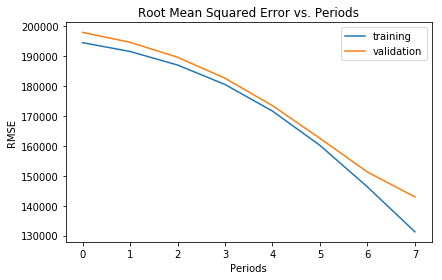

In [10]:
model2 = regressor_model(
    learning_rate=0.005,
    steps=500,
    batch_size=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols,
    m_dir='/tmp/model2',
    periods=8)

In [11]:
scores2 = model2[0].predict(input_fn=tf.estimator.inputs.pandas_input_fn(x=test,
                                                                      num_epochs=1,
                                                                      shuffle=False))
# 
res = []
for i, p in enumerate(scores2):
#     print (i)
    res.append([i + 1461, p['predictions'][0]])

result = pd.DataFrame(res, columns=['Id', 'SalePrice'])
result.to_csv('model2.csv', index=None)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model2/model.ckpt-160
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
